<img src="resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Workshop SWDB 2024 </h1> 
<h3 align="center">Day 3 2024 - Neuron Morphology</h3> 
<h3 align="center">Notebook 2: Morphological Features</h3> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
   
<p>Here we will begin quantifying the features we visualized in the previous notebook, including: 
    
<ul>
<li> path-length of axons and dendrites
<li> distribution of branch lengths
<li> relationship between axon and dendrite, re: branch number and path-length.
</ul>
    
</div>

In [1]:
#all imports
import pandas as pd
import numpy as np
from os.path import join as pjoin
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import cloudvolume
from meshparty import skeleton
import skeleton_plot as skelplot
import seaborn as sns

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
 
<h2> Load a precomputed skeleton </h2>

<p> Previously we viewed the Electron Microscopy (EM) and Light Microscopy (LM) reconstructions seperately. However, both datasets exist as part of the common coordinate framework (CFF). 

<p> You can see both example cells rendered in CCF in <a ref="https://spelunker.cave-explorer.org/#!middleauth+https://global.daf-apis.com/nglstate/api/v1/4754960374824960">Neuroglancer</a>.
    
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.1:</b>  Choose your own adventure: use either the EM or LM data path from the previous notebook. Return here later to select the other data type.
</div>

In [4]:
#Answer 1
input_directory = "precomputed://gs://allen_neuroglancer_ccf/em_minnie65_v661"
skeleton_id = 864691135591041291
cv_obj = cloudvolume.CloudVolume(input_directory, use_https = True) # Initialize cloud volume
cv_sk = cv_obj.skeleton.get(skeleton_id) #load an example skeleton

sk = skeleton.Skeleton(cv_sk.vertices, 
                       cv_sk.edges, 
                       vertex_properties={'radius': cv_sk.radius,
                                          'compartment': cv_sk.compartment}, 
                       root = len(cv_sk.edges), # the final edge is root
                       remove_zero_length_edges = False)

conversion_factor =1000 #for EM (data in nanometers) Need to figure out a nicer way to do this; can pull from skel info file maybe? cv_obj.resolution

In [3]:
#Answer 2 

input_directory = "precomputed://s3://aind-open-data/exaSPIM_609281_2022-11-03_13-49-18_reconstructions/precomputed"
skeleton_id = 14
cv_obj = cloudvolume.CloudVolume(input_directory) # Initialize cloud volume
cv_sk = cv_obj.skeleton.get(skeleton_id) #load an example skeleton


sk = skeleton.Skeleton(cv_sk.vertices, 
                       cv_sk.edges, 
                       vertex_properties={'radius': cv_sk.radius,
                                          'compartment': cv_sk.compartment}, 
                       root = 0, 
                       # root = len(sk_em.edges), # when the final edge is root
                       remove_zero_length_edges = False)

conversion_factor = 1 #for LM (data in microns )

KeyError: 'AWS_SESSION_TOKEN'

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h2> Calculate Basic Morphology features of the skeleton </h2>

<p> We will be using the <a href="https://github.com/CAVEconnectome/MeshParty/">MeshParty</a> toolbox which simplifies the process of extracting features like branches and endpoints, and calculating <b>path-lengths</b>--the distance in space traversed by the neurites.
    
</div>

In [4]:
#TODO: INCLUDE FIGURE TO EASILY EXPLAIN WHAT THESE FEATURES ARE

<font color='red'><b> ----- Section 1.1: Vertices and Neighborhoods ----- <font><b>

<font color='red'><b> Mention that each vertex stored is represented by an integer and has an xyz coordinate associated with it.<b>

<font color='red'><b> Is this a directed graph?<b>
     
<font color='red'><b> Also we should define what the nbhd of a node is and show how to extract it. This is important so that we can properly define a branch point and end point.<font><b>
    
    
<font color='blue'><b> Each vertex is represented by an integer and has an xyz coordinate associated to it. The neighborhood of a node includes all nodes that are directly connected to it by a single edge. Here is an example were we sample a random node and list its neighbors. <font><b>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h3> Number of Vertices </h3>
    
</div>

In [10]:
# Vertices
print(f"There are {len(sk.vertices)} vertices in this neuron")

There are 9154 vertices in this neuron


<font color="red"><b> It would be convenient to have a term for the set formed by the union of branch points, end points, and the root. Maybe irreducible/nontrivial/topological nodes? <font><b>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h3> Branch Points </h3>
    
</div>

<font color="red"><b> Under the heading "Branch Point", add the exact definition (i.e. Vertices with three or more neighbors). <font><b>

In [5]:
# Branch points
print("Branch points are at the following indices: \n",sk.branch_points)

Branch points are at the following indices: 
 [ 522  738 1115 1256 1263 1428 1493 1523 1535 1540 1632 1866 1878 1902
 1935 1951 1996 2030 2043 2074 2104 2170 2190 2243 2262 2271 2294 2304
 2384 2425 2445 2449 2484 2611 2616 2653 2687 2736 2755 2760 2775 2848
 2867 2972 3049 3057 3110 3176 3226 3302 3340 3386 3413 3423 3453 3513
 3516 3550 3558 3622 3638 3665 3688 3703 3721 3823 3972 4016 4024 4065
 4068 4096 4113 4161 4225 4285 4302 4366 4390 4466 4543 4718 4921 4959
 4985 5161 5176 5509 5518 5727 5746 5925 6800 7798 7858 7920 8463 8492
 8614 8632 8645 8755 8903 8933 9026 9057 9082 9153]


<font color="blue"><b> print("Branch points are the following vertices:\n", sk.branch_points) <font><b>
    
    
<font color="red"><b> I think it would be better to not use the term "indices" to refer to "vertices" for the sake of consistency. <font><b>    

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h3> End points </h3>
    
</div>

<font color="red"><b> Under the heading "End Point", add the definition (i.e. Vertices with exactly one neighbor.) <font><b>

In [7]:
# End points
print("End points are at the following indices: \n",sk.end_points)

End points are at the following indices: 
 [   5   29   31   68   86  170  172  177  218  245  286  291  323  335
  366  392  419  470  516  564  638  647  881  934  950 1286 1347 1351
 1544 1562 1661 1662 1672 1682 1743 1778 1781 1811 2008 2042 2072 2096
 2168 2259 2367 2370 2373 2470 2562 2622 2623 2638 2682 2756 2757 2842
 2882 2937 3030 3073 3130 3150 3193 3296 3395 3519 3720 3864 4051 4394
 4477 4502 4611 4679 4740 4771 4776 4813 4887 5131 5198 5547 5551 5591
 5597 5618 5663 5685 5823 5870 5891 6128 6146 6171 6181 6268 6314 6352
 6400 6426 6445 6546 6709 6780 6848 6874 6967 7028 7070 7093 7289 7531
 7822 8064 8252 8266 8323 8490 8497 8745 8861 8872 8931 9012 9014 9042
 9116 9152]


<font color="blue"><b> print("End points are the following vertices:\n", sk.end_points) <font><b>


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h3> Root Point </h3>
    
</div>

<font color="red"><b> Under the heading "Root Point", add the definition (i.e. Unique vertex that represents the soma.) <font><b>

<font color="red"><b> Maybe change "Root Point" to "Root". It looks a little funny because the graphs literature always uses "Root" and not "Root Point" but it's a very small detail. <font><b>
    
<font color="red"><b>  Another detail is that usually when you say "Root" it means that the graph is directed and the root is a node without any parents. <font><b>

In [7]:
# Root - point associated with the root node, which is the soma
print("Root point with skeleton indices: ", sk.root.item())

Root point with skeleton indices:  9153


<font color="blue"><b> print("Root is vertex:\n", sk.root.item()) <font><b>


<font color="red"><b>  Exercise: Find the branch point with the most neighbors. <font><b>

<font color="red"><b>  Exercise: Print out the degree distribution of the neuron (i.e. the fraction of nodes with 1, 2, ..., k neighbors). <font><b>

<font color='red'><b> Exercise: Based on the results of the previous exercise, explain why the topology of a neuron is nearly a cayley tree. <font><b>
    

<font color='red'><b> ----- Section 1.2: Paths and Segments ----- <font><b>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h3> Segments</h3
    
</div>

<font color="red"><b> We need to carefully define what a segment is. Is it the path of nodes between two vertices i and j which are assumed to be a root, branch point, or endpoint (i.e. irreducible/topoogical/nontrial node)? <font><b>
    
<font color="red"><b> Given two nodes, how do you find the path between them? <font><b>

<font color="red"><b> Given a branching/end point, how would you find all of the segments that emanate from it? <font><b>
    
<font color="red"><b> How would you find the sequence of segments that connect the soma to any leaf node? <font><b>
    
<font color="red"><b> Maybe we want to introduce the term "hop" (i.e. the number of segments between a root, branch point, or end point). This is a topological notion of distance, whereas path length is a geometric notion of distance <font><b>
        
<font color="red"><b> Exercise: Find the endpoint with the longest sequence of segments that connects it to the root. <font><b>
 
<font color="red"><b> Exercise: Print out the distribution of hop distances between endpoints and the soma (i.e. the fraction of endpoints that are 1, 2, ..., k hops from the soma). <font><b>
    
<font color="red"><b> Exercise: Compute the cumulative distribution of distance-from-soma for branching points (i.e. given a distance d > 0, what fraction of branching points have a path length of at most d microns from the soma.). Are there any distances that you see lots of branching?<font><b>   

In [11]:
# Segments - the continuous branch segments
#Branch points
print("All branch segments are: \n",len(sk.segments))

All branch segments are: 
 236


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h3> Calculate pathlength </h3
    
<p> Use the skeleton meshwork's <code>path_length()</code> function to calculate the path-length for the whole neuron
    
</div>

<font color='red'><b> We need to be more careful here. In graph theory, a path refers to a sequence of vertices that connect two given vertices. The path length is the number of vertices in this path. When you calculate path length here, you're talking about a physical distance and so we need to be more clear that each node has an xyz coordinate that is being used to compute the path length. <font><b>
    
<font color='red'><b> How do you compute the path length between two nodes? <font><b>    
    

In [8]:
# Path-length for all neurites
full_pathlength = sk.path_length() / conversion_factor # Convert to nanometers
print("Path-length of the entire neuron: ", full_pathlength, ' um')

Path-length of the entire neuron:  20129.62  um


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p> Use the pathlength operation on subsets of the path as well
    
</div>

In [9]:
# Path-length for arbitrary segment
segment_pathlength = sk.path_length(sk.segments[11]) / conversion_factor # Convert to nanometers 
print("Path-length of one segment: ", segment_pathlength, ' um')

Path-length of one segment:  26.120412109375  um


<font color='red'><b> ----- Section 1.3: Subgraphs ----- <font><b>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h3> Using Masks to Select Parts of the Skeleton </h3
    
<p> One of the most useful features of the skeleton meshwork's is the ability to <b>mask</b> or select only parts of the skeleton to work with at a time. The function <code>apply_mask()</code> acts on the meshwork skeleton, and will apply in place if <code>apply_mask(in_place=True)</code>. 

<p>
    
<p> <b><i>Warning</i></b>: be aware when setting a mask in place--mask operations are additive. To reset the mask completely, use <code>reset_mask(in_place=True)</code>.
    
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p> Let's select a set of nodes from segment 11:
    
</div>

<font color="red"><b> Is there an intuitive way of accessing segments, we have no idea what segment 11 is. What if we sample a branching point that is one hop from the root and compute the path length of that segment. Then when we go to concatenate segments, let's take a segment that's one hop away. As an exercise, combine all of the segments that are descendents of the initial segment that we sampled. This exercise would set up the students to analyze whole branches (i.e. all descendents of a segment directly connected to the origin). <font><b>

In [10]:
selected_nodes = sk.segments[11]
print(selected_nodes)

[291 290 308 306 304 331 332 358 379 380 401 428 452 484]


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p> Apply a mask to these nodes:
    
</div>

In [11]:
#reset to make sure you have the full skeleton
sk.reset_mask(in_place=True)
# Apply mask
sk_masked = sk.apply_mask(selected_nodes)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p> Check that this masked skeleton matches the pathlength calculated above
    
</div>

In [12]:
sk_masked.path_length() / conversion_factor

26.120412109375

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.2:</b>  What if you want to combine segments 11 and 12 ?
</div>

<font color='red'><b> Do the segments have to be connected? <font><b>

In [13]:
#Answer
selected_nodes = np.concatenate([sk.segments[11], sk.segments[12]])
sk.reset_mask(in_place=True)
sk_masked = sk.apply_mask(selected_nodes)
sk_masked.path_length() / conversion_factor

245.460765625

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h3> Selecting Axons and Dendrites </h3>
    
<p> Critically, <code>apply_mask()</code> allows us to mask a neuron according to its compartment label: axon, dendrite, soma, etc. 
    
<p> <b>Compartment label conventions</b> (from standardized swc files <a href="www.neuromorpho.org">www.neuromorpho.org</a>
<ul>
<li> 0 - undefined
<li> 1 - soma
<li> 2 - axon
<li> 3 - (basal) dendrite
<li> 4 - apical dendrite
<li> 5+ - custom
</ul>
    
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p>Create a skeleton only with the dendrites and compute its path length
    
</div>

In [14]:
sk.vertex_properties['compartment']

array([2., 2., 2., ..., 2., 2., 1.], dtype=float32)

In [15]:
# Select the indices associated with the axon, and dendrites

dendrite_inds = (sk.vertex_properties['compartment']==3) | (sk.vertex_properties['compartment']==4)| (sk.vertex_properties['compartment']==1) #soma is included here to connect the dendrite graphs 

# create new skeleton that masks (selects) only the axon
sk_dendrite = sk.apply_mask(dendrite_inds)
print("Dendrite pathlength of all branches is : ", sk_dendrite.path_length() / conversion_factor, ' um')

Dendrite pathlength of all branches is :  5757.4085  um


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.3:</b>  Create an axon skeleton and compute its path length
</div>

<font color='red'><b> Exercise: Do axons or dendrites have more branching points? What if you consider the number of branching points relative to the path length? How do these values compare if we sample a single axon or dendrite <font><b>

In [26]:
#Answer
axon_inds = sk.vertex_properties['compartment']==2
sk_axon = sk.apply_mask(axon_inds)
print("Axon pathlength is : ", sk_axon.path_length() / conversion_factor, ' um')


Axon pathlength is :  14324.654  um


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p> Let's look at all the segments/branches in dendrite graph
    
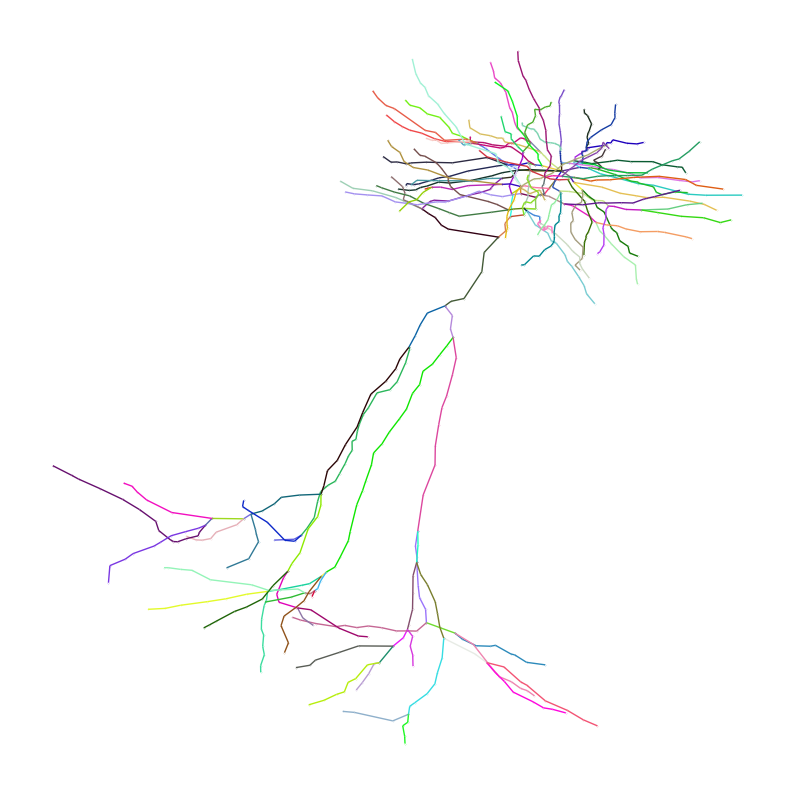
</div>

<font color='red'><b> ----- Section 1.4: Analyzing the Morphology of a Single Neuron ----- <font><b>


In [51]:
#NEED TO FIGURE THIS OUT

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p> Note that each have different lengths. Let's create a histogram of all the path lengths of the segments/branches in dendrite graph
    
</div>

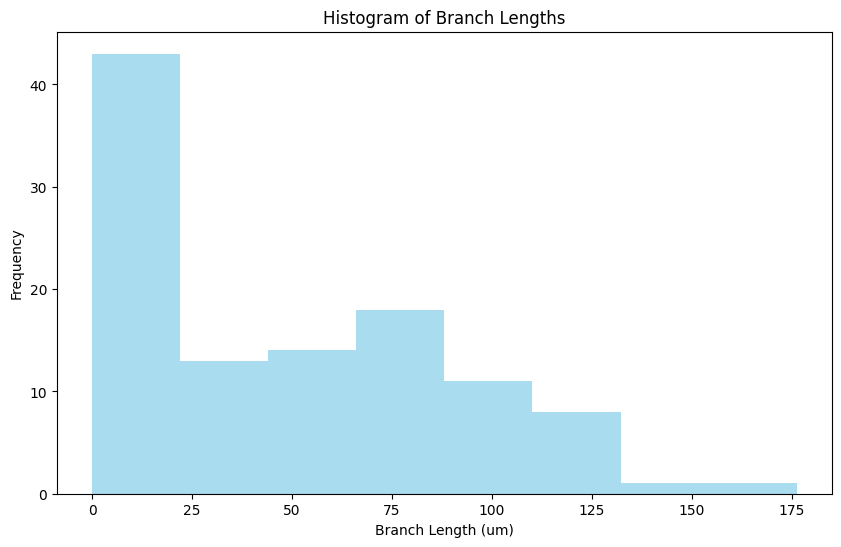

In [29]:
#find Branch lengths
branch_lengths = np.array([sk_dendrite.path_length(seg) for seg in sk_dendrite.segments]) / conversion_factor
plt.figure(figsize=(10, 6))
plt.hist(branch_lengths, bins='auto', color='skyblue', alpha=0.7)
plt.title("Histogram of Branch Lengths")
plt.xlabel("Branch Length (um)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
#TODO:

In [ ]:
''' computing the longest path '''

In [ ]:
'''computing the shortest path  - exercise '''

In [ ]:
''' plot the longest path overlaid'''

<font color='red'><b> ----- Section 1.5: Comparing the Morphology of Multiple Neurons ----- <font><b>


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h3> Looking at features of Many Neurons Together </h3
    
<p> Here we try to plot axon length vs dendrite length by selecting a random set. However, this set can be chosen based on some manual or automatic criterion for analysis. 
    
</div>

In [16]:
''' read 10 neurons '''
#For EM:
Ids = [864691135591041291, 864691135397503777, 864691135953985800,
       864691135988854016, 864691135473091634, 864691135698631701,
       864691135701034107, 864691135816565839, 864691135307804742,
       864691135469422674,]

#For LM 
# Ids = [1,2,3,4,5,7,9,14,16,17]

In [17]:
'''do a scatter of axon length to dendrite length'''
ax = []
de = []

# input_directory = "precomputed://s3://aind-open-data/exaSPIM_609281_2022-11-03_13-49-18_reconstructions/precomputed"
# cv_obj = cloudvolume.CloudVolume(input_directory) # Initialize cloud volume

input_directory = "precomputed://gs://allen_neuroglancer_ccf/em_minnie65_v661"
cv_obj = cloudvolume.CloudVolume(input_directory, use_https=True) # Initialize cloud volume

for skeleton_id in Ids:
    #read precomputed
    
    cv_sk = cv_obj.skeleton.get(skeleton_id) #load an example skeleton
    
    #read skeleton
    sk = skeleton.Skeleton(cv_sk.vertices, 
                       cv_sk.edges, 
                       vertex_properties={'radius': cv_sk.radius,
                                          'compartment': cv_sk.compartment}, 
                       # root = 0, 
                       root = len(cv_sk.edges), # when the final edge is root
                       remove_zero_length_edges = False)
    
    #select axon
    axon_inds = sk.vertex_properties['compartment']==2
    sk_axon = sk.apply_mask(axon_inds)
    
    #calculate, append pathlength
    ax.append(sk_axon.path_length()/conversion_factor)
    
    #select dendrite
    dendrite_inds = (sk.vertex_properties['compartment']==3) | (sk.vertex_properties['compartment']==4)| (sk.vertex_properties['compartment']==1) #soma is included here to connect the dendrite graphs 
    sk_dendrite = sk.apply_mask(dendrite_inds)
    
    #calculate, append pathlength
    de.append(sk_dendrite.path_length()/conversion_factor)    


<Axes: xlabel='dendrite length', ylabel='axon length'>

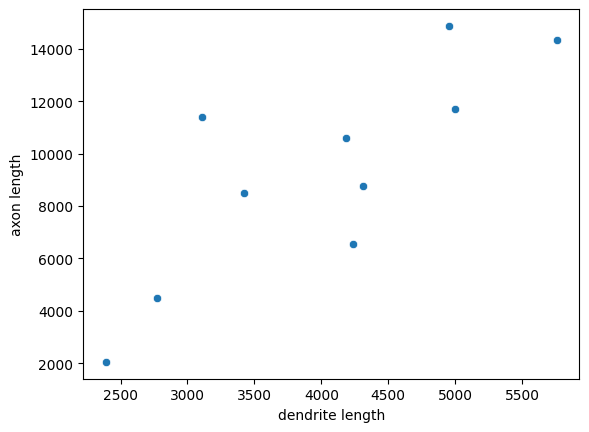

In [18]:
#plot axon vs dendrite lengths
d = {'axon length': ax, 'dendrite length': de}
dataframe = pd.DataFrame(data=d)
sns.scatterplot(data = dataframe, y ="axon length", x= "dendrite length")

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; "> 
    
<h2> Exercises </h2
    
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h3> Selecting Downstream points</h3>
    
<p> Meshwork has a nifty function for subselecting points: downstream points. For a given point, downstream points are defined as points on paths from endpoints to the root which are further than the given point. For example, if the skeleton path is : A-B-C-D-E where A is the root, D and E are downstream points of C. With branching, this can be more complex. To find the downstream points from say the 30th branch point, we can do:
    
</div>

In [19]:
# Select downstream nodes from one branch point
downstream_nodes = sk.downstream_nodes(sk.branch_points[30])

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.2:</b>  How would you calculate the path length of the downstream nodes you selected above?
</div>

In [ ]:
downstream_pathlength = 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; "> 
    
<h3> visualize downstream path </h3
    
</div>

(7748714.5, 8427627.0, 1569414.875, 841751.375)

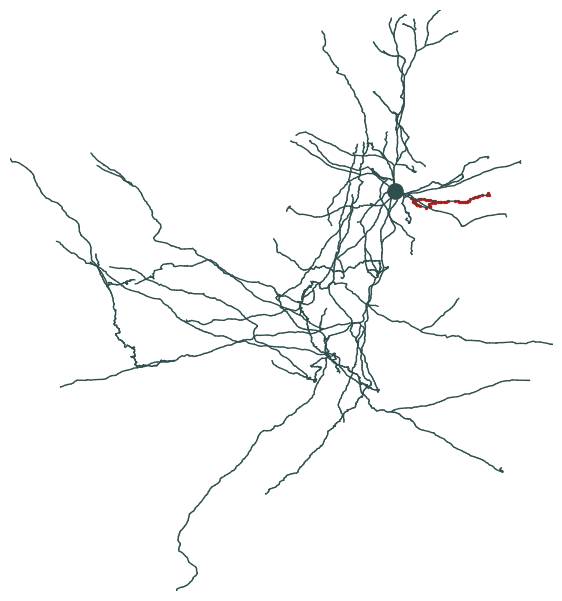

In [20]:
f, ax = plt.subplots(figsize=(7, 10))
skelplot.plot_tools.plot_skel(
    sk,
    line_width = 1,
    plot_soma = True,
    invert_y = True,
    x="x",
    y="y",
)

# Add the downstream vertices as red points (Note: this works for x-y plot orientation; select the columns appropriate to your skeleton orientation)
ax.scatter(sk.vertices[downstream_nodes][:,0], sk.vertices[downstream_nodes][:,1], c='r', s=2)

ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['bottom'].set_visible(False)
ax.axis('off')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; "> 
    
#### acccessory code
    
</div>

[864691136452054015,
 864691136309871706,
 864691134940133219,
 864691135954311176,
 864691136371168136,
 864691135118298333,
 864691135561619681,
 864691135785592004,
 864691136903144370,
 864691135571557925,
 864691135740654187,
 864691135429699888,
 864691136618564493,
 864691135591041291,
 864691135397503777,
 864691135848903518,
 864691135809608652,
 864691135753932237,
 864691135953985800,
 864691135988854016,
 864691135571154925,
 864691135693735103,
 864691135684284914,
 864691135976155459,
 864691136143786292,
 864691135303514791,
 864691135568328684,
 864691135809759436,
 864691135473091634,
 864691135737446276,
 864691135698631701,
 864691135946995809,
 864691137197329985,
 864691135855791662,
 864691135341465029,
 864691135701034107,
 864691136618908301,
 864691135489383226,
 864691135100167712,
 864691136662432990,
 864691135857324590,
 864691135816565839,
 864691135279181729,
 864691135490941927,
 864691135307804742,
 864691137197468481,
 864691135013445270,
 864691136008

In [1]:
# directory functions; # note: skeleton.get() accepts a list of ids
from cloudfiles import CloudFiles

cf = CloudFiles(cv_obj.cloudpath)

# get segment info
segment_properties = cf.get_json("segment_properties/info")

skeleton_list = segment_properties['inline']['ids']
skeleton_list = [int(i) for i in skeleton_list]


# # load all skeletons in list; returns list of skeleton objects
# cv_obj.skeleton.get(skeleton_list)

NameError: name 'cv_obj' is not defined

<font color='red'><b> Here are some general comments <font><b>
    
<font color='red'><b> --> We need to be more careful about having good definitions in the introductory part of this
 notebook (e.g. neighborhood/parents+children, end point, branch point, root, undirected/directed edges). <font><b>
        
<font color='red'><b> --> We could discuss that studying the morphology of a neuron involves analyzing both its geometry and topology of the skeleton which are intertwined. This notebook primarily concentrates on analyzing the
geometric aspects of the skeleton, such as path lengths. We could include additional content on examining the topological properties of neurons, such as branching structure. <font><b>